In [57]:
import pystare
import geopandas
import starepandas
import datetime
import matplotlib.pyplot as plt
import dask

In [59]:
# Load Country
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
brazil = countries[countries.name=='Brazil']
stare = starepandas.stare_from_gdf(brazil, level=8, force_ccw=True)
brazil = starepandas.STAREDataFrame(brazil, stare=stare)

# Load Granule
fname = '../tests/data/granules/MYD05_L2.A2020060.1635.061.2020061153519.hdf'
modis = starepandas.read_granule(fname)
geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

In [60]:
len(stare[0])

1210

In [61]:
# STARE based intersects
sids_brazil = brazil['stare'].iloc[0]
sids_modis = list(modis['stare'])

start = datetime.datetime.now()
intersects_stare = pystare.intersects(sids_brazil, sids_modis)
print(datetime.datetime.now() - start)

0:00:00.623622


In [62]:
# Conventional shapely based instersects test.

# pygeos integration is still fragile but may speed up things 
geopandas.options.use_pygeos = False

start = datetime.datetime.now()
intersects = modis.intersects(brazil.geometry.iloc[0])
print(datetime.datetime.now() - start)

0:00:02.893493


In [63]:
brazil.set_trixels(inplace=True)

<AxesSubplot:>

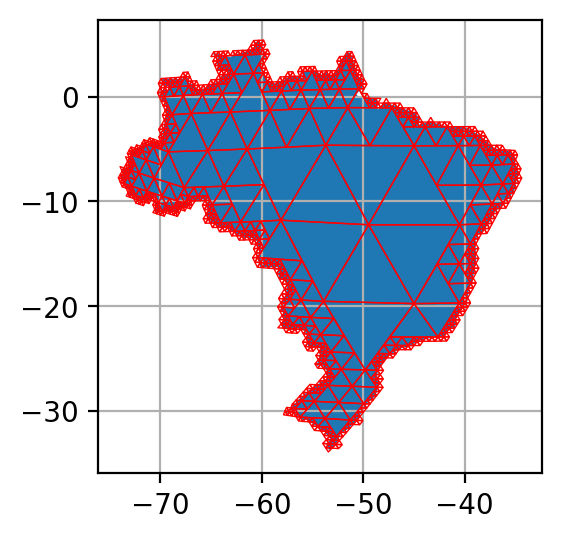

In [64]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

brazil.plot(ax=ax)
brazil.plot(ax=ax, trixels=True, boundary=True, linewidth=0.5, color='red')

# Parallel

In [47]:
fname = 'VNP03DNB.A2020219.0742.001.2020219124651.nc'

n_workers = 50
sids_series = modis['stare']
ddf = dask.dataframe.from_pandas(sids_series, npartitions=n_workers)

In [48]:
meta = {'intersects': 'bool'}
res = ddf.map_partitions(lambda df: pystare.intersects(sids_brazil, df, 1), meta=meta)

In [49]:
a = res.compute(scheduler='processes')

In [50]:
len(a)

109620

In [51]:
intersects_stare = pystare.intersects(sids_brazil, sids_modis)

In [52]:
len(intersects_stare)

109620